# Hugging Face Transformers 微调语言模型-问答任务# 
我们已经学会使用 Pipeline 加载支持问答任务的预训练模型，本教程代码将展示如何微调训练一个支持问答任务的模型。# 

注意：微调后的模型仍然是通过提取上下文的子串来回答问题的，而不是生成新的文本。

In [1]:
# 根据你使用的模型和GPU资源情况，调整以下关键参数
squad_v2 = False
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

# 下载数据集# 
在本教程中，我们将使用斯坦福问答数据集(SQuAD）。# 

SQuAD 数据集
斯坦福问答数据集(SQuAD) 是一个阅读理解数据集，由众包工作者在一系列维基百科文章上提出问题组成。每个问题的答案都是相应阅读段落中的文本片段或范围，或者该问题可能无法回答。

SQuAD2.0将SQuAD1.1中的10万个问题与由众包工作者对抗性地撰写的5万多个无法回答的问题相结合，使其看起来与可回答的问题类似。要在SQuAD2.0上表现良好，系统不仅必须在可能时回答问题，还必须确定段落中没有支持任何答案，并放弃回答。

In [2]:
from datasets import load_dataset

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

Generating validation split: 100%|██████████| 10570/10570 [00:00<00:00, 465026.78 examples/s]


The datasets object itself is DatasetDict, which contains one key for the training, validation and test set.

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

# 对比数据集# 
相比快速入门使用的 Yelp 评论数据集，我们可以看到 SQuAD 训练和测试集都新增了用于上下文、问题以及问题答案的列：# 

YelpReviewFull Dataset# ：

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5# 0000
    })
})

In [6]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

从上下文中组织回复内容
我们可以看到答案是通过它们在文本中的起始位置（这里是第515个字符）以及它们的完整文本表示的，这是上面提到的上下文的子字符串。

In [7]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [8]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,572fc34c947a6a140053cc71,Armenia,"Due to its position between two unfriendly neighbours, Armenia has close security ties with Russia. At the request of the Armenian government, Russia maintains a military base in the northwestern Armenian city of Gyumri as a deterrent against Turkey.[citation needed] Despite this, Armenia has also been looking toward Euro-Atlantic structures in recent years. It maintains good relations with the United States especially through its Armenian diaspora. According to the US Census Bureau, there are 427,822 Armenians living in the country.",Who gave Russia permission to have a military base in Gyumri?,"{'text': ['Armenian government'], 'answer_start': [122]}"
1,570c481ffed7b91900d45826,Mary_(mother_of_Jesus),"In the 19th century, a house near Ephesus in Turkey was found, based on the visions of Anne Catherine Emmerich, an Augustinian nun in Germany. It has since been visited as the House of the Virgin Mary by Roman Catholic pilgrims who consider it the place where Mary lived until her assumption. The Gospel of John states that Mary went to live with the Disciple whom Jesus loved,[Jn 19:27] identified as John the Evangelist.[citation needed] Irenaeus and Eusebius of Caesarea wrote in their histories that John later went to Ephesus, which may provide the basis for the early belief that Mary also lived in Ephesus with John.",Whose visions led to the identification of the House of the Virgin Mary?,"{'text': ['Anne Catherine Emmerich'], 'answer_start': [87]}"
2,57282dda4b864d1900164660,Gamal_Abdel_Nasser,"On 21 May, Amer asked Nasser to order the Straits of Tiran blockaded, a move Nasser believed Israel would use as a casus belli. Amer reassured him that the army was prepared for confrontation, but Nasser doubted Amer's assessment of the military's readiness. According to Nasser's vice president Zakaria Mohieddin, although ""Amer had absolute authority over the armed forces, Nasser had his ways of knowing what was really going on"". Moreover, Amer anticipated an impending Israeli attack and advocated a preemptive strike. Nasser refused the call upon determination that the air force lacked pilots and Amer's handpicked officers were incompetent. Still, Nasser concluded that if Israel attacked, Egypt's quantitative advantage in manpower and arms could stave off Israeli forces for at least two weeks, allowing for diplomacy towards a ceasefire. Towards the end of May, Nasser increasingly exchanged his positions of deterrence for deference to the inevitability of war, under increased pressure to act by both the general Arab populace and various Arab governments. On 26 May Nasser declared, ""our basic objective will be to destroy Israel"". On 30 May, King Hussein committed Jordan in an alliance with Egypt and Syria.",What thoroughfare did Amir want Nasser to block?,"{'text': ['Straits of Tiran'], 'answer_start': [42]}"
3,56fb623d8ddada1400cd63bd,Middle_Ages,"As Western Europe witnessed the formation of new kingdoms, the Eastern Roman Empire remained intact and experienced an economic revival that lasted into the early 7th century. There were fewer invasions of the eastern section of the empire; most occurred in the Balkans. Peace with Persia, the traditional enemy of Rome, lasted throughout most of the 5th century. The Eastern Empire was marked by closer relations between the political state and Christian Church, with doctrinal matters assuming an importance in eastern politics that they did not have in Western Europe. Legal developments included the codification of Roman law; the first effort—the Theodosian Code—was completed in 438. Under Emperor Justinian (r. 527–565), another compilation took place—the Corpus Juris Civilis. Justinian also oversaw the construction of the Hagia Sophia in Constantinople and the reconquest of North Africa from the Vandals and Italy from the Ostrogoths, under Belisarius (d. 565). The conquest of Italy was not complete, as a deadly outbreak of

# 预处理数据

In [9]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 157kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 2.81MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 540kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.15MB/s]


以下断言确保我们的 Tokenizers 使用的是 FastTokenizer（Rust 实现，速度和功能性上有一定优势）。

In [10]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

您可以在大模型表上查看哪种类型的模型具有可用的快速标记器，哪种类型没有。

您可以直接在两个句子上调用此标记器（一个用于答案，一个用于上下文）：

In [11]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Tokenizer 进阶操作
在问答预处理中的一个特定问题是如何处理非常长的文档。

在其他任务中，当文档的长度超过模型最大句子长度时，我们通常会截断它们，但在这里，删除上下文的一部分可能会导致我们丢失正在寻找的答案。

为了解决这个问题，我们允许数据集中的一个（长）示例生成多个输入特征，每个特征的长度都小于模型的最大长度（或我们设置的超参数）。

In [12]:
# The maximum length of a feature (question and context)
max_length = 384 
# The authorized overlap between two part of the context when splitting it is needed.
doc_stride = 128 

### 超出最大长度的文本数据处理
下面，我们从训练集中找出一个超过最大长度（384）的文本：

In [13]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
# 挑选出来超过384（最大长度）的数据样例
example = datasets["train"][i]

In [14]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

### 截断上下文不保留超出部分

In [15]:
len(tokenizer(example["question"],
              example["context"],
              max_length=max_length,
              truncation="only_second")["input_ids"])

384

### 关于截断的策略
直接截断超出部分: truncation=only_second

仅截断上下文（context），保留问题（question）：return_overflowing_tokens=True & 设置stride

In [16]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

### 使用此策略截断后，Tokenizer 将返回多个 input_ids 列表。

In [17]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

解码两个输入特征，可以看到重叠的部分：

In [18]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

2024-02-23 11:35:18.018026: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 11:35:18.605638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 11:35:18.605719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 11:35:18.668273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 11:35:18.884233: I tensorflow/core/platform/cpu_feature_guar

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

### 使用 offsets_mapping 获取原始的 input_ids
设置 return_offsets_mapping=True，将使得截断分割生成的多个 input_ids 列表中的 token，通过映射保留原始文本的 input_ids。

如下所示：第一个标记（[CLS]）的起始和结束字符都是（0, 0），因为它不对应问题/答案的任何部分，然后第二个标记与问题(question)的字符0到3相同.

In [19]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

因此，我们可以使用这个映射来找到答案在给定特征中的起始和结束标记的位置。

我们只需区分偏移的哪些部分对应于问题，哪些部分对应于上下文。

In [21]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

how How


In [22]:
second_token_id = tokenized_example["input_ids"][0][2]
offsets = tokenized_example["offset_mapping"][0][2]
print(tokenizer.convert_ids_to_tokens([second_token_id])[0], example["question"][offsets[0]:offsets[1]])

many many


In [23]:
example["question"]

"How many wins does the Notre Dame men's basketball team have?"

### 借助tokenized_example的sequence_ids方法，我们可以方便的区分token的来源编号：

对于特殊标记：返回None，
对于正文Token：返回句子编号（从0开始编号）。
综上，现在我们可以很方便的在一个输入特征中找到答案的起始和结束 Token。

In [24]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [25]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# 当前span在文本中的起始标记索引。
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# 当前span在文本中的结束标记索引。
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# 检测答案是否超出span范围（如果超出范围，该特征将以CLS标记索引标记）。
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # 将token_start_index和token_end_index移动到答案的两端。
    # 注意：如果答案是最后一个单词，我们可以移到最后一个标记之后（边界情况）。
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("答案不在此特征中。")

23 26


打印检查是否准确找到了起始位置：

In [26]:
# 通过查找 offset mapping 位置，解码 context 中的答案 
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
# 直接打印 数据集中的标准答案（answer["text"])
print(answers["text"][0])

over 1, 600
over 1,600


### 关于填充的策略
对于没有超过最大长度的文本，填充补齐长度。
对于需要左侧填充的模型，交换 question 和 context 顺序

In [29]:
pad_on_right = tokenizer.padding_side == "right"

### 整合以上所有预处理步骤
让我们将所有内容整合到一个函数中，并将其应用到训练集。

针对不可回答的情况（上下文过长，答案在另一个特征中），我们为开始和结束位置都设置了cls索引。

如果allow_impossible_answers标志为False，我们还可以简单地从训练集中丢弃这些示例。

In [27]:
def prepare_train_features(examples):
    # 一些问题的左侧可能有很多空白字符，这对我们没有用，而且会导致上下文的截断失败
    # （标记化的问题将占用大量空间）。因此，我们删除左侧的空白字符。
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # 使用截断和填充对我们的示例进行标记化，但保留溢出部分，使用步幅（stride）。
    # 当上下文很长时，这会导致一个示例可能提供多个特征，其中每个特征的上下文都与前一个特征的上下文有一些重叠。
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # 由于一个示例可能给我们提供多个特征（如果它具有很长的上下文），我们需要一个从特征到其对应示例的映射。这个键就提供了这个映射关系。
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # 偏移映射将为我们提供从令牌到原始上下文中的字符位置的映射。这将帮助我们计算开始位置和结束位置。
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # 让我们为这些示例进行标记！
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # 我们将使用 CLS 特殊 token 的索引来标记不可能的答案。
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # 获取与该示例对应的序列（以了解上下文和问题是什么）。
        sequence_ids = tokenized_examples.sequence_ids(i)

        # 一个示例可以提供多个跨度，这是包含此文本跨度的示例的索引。
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # 如果没有给出答案，则将cls_index设置为答案。
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # 答案在文本中的开始和结束字符索引。
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # 当前跨度在文本中的开始令牌索引。
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # 当前跨度在文本中的结束令牌索引。
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # 检测答案是否超出跨度（在这种情况下，该特征的标签将使用CLS索引）。
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # 否则，将token_start_index和token_end_index移到答案的两端。
                # 注意：如果答案是最后一个单词（边缘情况），我们可以在最后一个偏移之后继续。
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

### datasets.map 的进阶使用
使用 datasets.map 方法将 prepare_train_features 应用于所有训练、验证和测试数据：

batched: 批量处理数据。
remove_columns: 因为预处理更改了样本的数量，所以在应用它时需要删除旧列。
load_from_cache_file：是否使用datasets库的自动缓存
datasets 库针对大规模数据，实现了高效缓存机制，能够自动检测传递给 map 的函数是否已更改（因此需要不使用缓存数据）。如果在调用 map 时设置 load_from_cache_file=False，可以强制重新应用预处理。

In [30]:
tokenized_datasets = datasets.map(prepare_train_features,
                                  batched=True,
                                  remove_columns=datasets["train"].column_names)

Map: 100%|██████████| 10570/10570 [00:03<00:00, 3092.16 examples/s]


### 微调模型
现在我们的数据已经准备好用于训练，我们可以下载预训练模型并进行微调。

由于我们的任务是问答，我们使用 AutoModelForQuestionAnswering 类。(对比 Yelp 评论打分使用的是 AutoModelForSequenceClassification 类）

警告通知我们正在丢弃一些权重（vocab_transform 和 vocab_layer_norm 层），并随机初始化其他一些权重（pre_classifier 和 classifier 层）。在微调模型情况下是绝对正常的，因为我们正在删除用于预训练模型的掩码语言建模任务的头部，并用一个新的头部替换它，对于这个新头部，我们没有预训练的权重，所以库会警告我们在用它进行推理之前应该对这个模型进行微调，而这正是我们要做的事情。

In [31]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

model.safetensors: 100%|██████████| 268M/268M [03:18<00:00, 1.35MB/s] 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs

### 训练超参数（TrainingArguments）

In [33]:
batch_size=64
model_dir = f"models/{model_checkpoint}-finetuned-squad"

args = TrainingArguments(
    output_dir=model_dir,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

### Data Collator（数据整理器）
数据整理器将训练数据整理为批次数据，用于模型训练时的批次处理。本教程使用默认的 default_data_collator。

In [34]:
from transformers import default_data_collator

data_collator = default_data_collator

### 实例化训练器（Trainer）
为了减少训练时间（需要大量算力支持），我们不在本教程的训练模型过程中计算模型评估指标。

而是训练完成后，再独立进行模型评估。

In [35]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

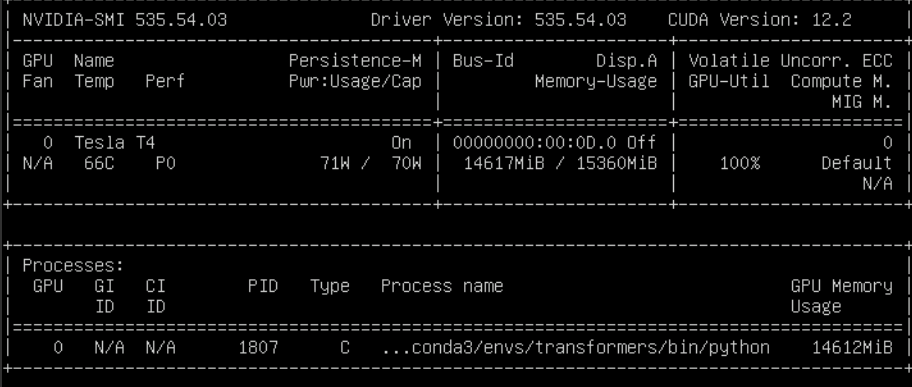

In [36]:
trainer.train()

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.500500,1.254940
2,1.123200,1.156738
3,0.985700,1.160583


TrainOutput(global_step=4152, training_loss=1.3181668062889966, metrics={'train_runtime': 8838.3167, 'train_samples_per_second': 30.048, 'train_steps_per_second': 0.47, 'total_flos': 2.602335381127373e+16, 'train_loss': 1.3181668062889966, 'epoch': 3.0})

### 训练完成后，第一时间保存模型权重文件

In [38]:
model_to_save = trainer.save_model(model_dir)

### 模型评估
评估模型输出需要一些额外的处理：将模型的预测映射回上下文的部分。

模型直接输出的是预测答案的起始位置和结束位置的logits

In [39]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

模型的输出是一个类似字典的对象，其中包含损失（因为我们提供了标签），以及起始和结束logits。我们不需要损失来进行预测，让我们看一下logits：

In [40]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([64, 384]), torch.Size([64, 384]))

In [41]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 46,  57,  78,  54, 118, 107,  72,  35, 107,  34,  73,  41,  80,  91,
         156,  35,  83,  91,  80,  58,  77,  31,  42,  53,  41,  35,  42,  77,
          11,  44,  27, 133,  66,  40,  87,  44,  85,  83, 127,  26,  28,  33,
          87, 127,  95,  25,  43,  22,  42,  29,  44,  46,  24,  44,  65,  58,
          81,  14,  59,  72,  25,  36,  57,  43], device='cuda:0'),
 tensor([ 47,  58,  81,  44, 118, 109,  75,  37, 109,  36,  76,  42,  83,  94,
         158,  35,  83,  94,  83,  60,  80,  74,  43,  54,  42,  35,  43,  80,
          13,  45,  28, 133,  66,  41,  89,  45,  87,  42, 127,  27,  30,  34,
          89, 127,  97,  26,  44, 132,  43,  30,  45,  47,  25,  45,  65,  59,
          81,  14,  60,  72,  25,  36,  58,  43], device='cuda:0'))

#### 如何从模型输出的位置 logit 组合成答案
我们有每个特征和每个标记的logit。在每个特征中为每个标记预测答案最明显的方法是，将起始logits的最大索引作为起始位置，将结束logits的最大索引作为结束位置。

在许多情况下这种方式效果很好，但是如果此预测给出了不可能的结果该怎么办？比如：起始位置可能大于结束位置，或者指向问题中的文本片段而不是答案。在这种情况下，我们可能希望查看第二好的预测，看它是否给出了一个可能的答案，并选择它。

选择第二好的答案并不像选择最佳答案那么容易：

它是起始logits中第二佳索引与结束logits中最佳索引吗？
还是起始logits中最佳索引与结束logits中第二佳索引？
如果第二好的答案也不可能，那么对于第三好的答案，情况会更加棘手。
为了对答案进行分类，

将使用通过添加起始和结束logits获得的分数
设计一个名为n_best_size的超参数，限制不对所有可能的答案进行排序。
我们将选择起始和结束logits中的最佳索引，并收集这些预测的所有答案。
在检查每一个是否有效后，我们将按照其分数对它们进行排序，并保留最佳的答案。
以下是我们如何在批次中的第一个特征上执行此操作的示例：

In [42]:
n_best_size = 20

In [43]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()

# 获取最佳的起始和结束位置的索引：
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

valid_answers = []

# 遍历起始位置和结束位置的索引组合
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index:  # 需要进一步测试以检查答案是否在上下文中
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": ""  # 我们需要找到一种方法来获取与上下文中答案对应的原始子字符串
                }
            )

然后，我们可以根据它们的得分对valid_answers进行排序，并仅保留最佳答案。唯一剩下的问题是如何检查给定的跨度是否在上下文中（而不是问题中），以及如何获取其中的文本。为此，我们需要向我们的验证特征添加两个内容：

生成该特征的示例的ID（因为每个示例可以生成多个特征，如前所示）；
偏移映射，它将为我们提供从标记索引到上下文中字符位置的映射。
这就是为什么我们将使用以下函数稍微不同于prepare_train_features来重新处理验证集：

In [44]:
def prepare_validation_features(examples):
    # 一些问题的左侧有很多空白，这些空白并不有用且会导致上下文截断失败（分词后的问题会占用很多空间）。
    # 因此我们移除这些左侧空白
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # 使用截断和可能的填充对我们的示例进行分词，但使用步长保留溢出的令牌。这导致一个长上下文的示例可能产生
    # 几个特征，每个特征的上下文都会稍微与前一个特征的上下文重叠。
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # 由于一个示例在上下文很长时可能会产生几个特征，我们需要一个从特征映射到其对应示例的映射。这个键就是为了这个目的。
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # 我们保留产生这个特征的示例ID，并且会存储偏移映射。
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # 获取与该示例对应的序列（以了解哪些是上下文，哪些是问题）。
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # 一个示例可以产生几个文本段，这里是包含该文本段的示例的索引。
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # 将不属于上下文的偏移映射设置为None，以便容易确定一个令牌位置是否属于上下文。
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

将prepare_validation_features应用到整个验证集：

In [45]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

Map: 100%|██████████| 10570/10570 [00:04<00:00, 2394.49 examples/s]


##### Now we can grab the predictions for all features by using the Trainer.predict method:

In [46]:
raw_predictions = trainer.predict(validation_features)

Trainer会隐藏模型不使用的列（在这里是example_id和offset_mapping，我们需要它们进行后处理），所以我们需要将它们重新设置回来：

In [47]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

现在，我们可以改进之前的测试：

由于在偏移映射中，当它对应于问题的一部分时，我们将其设置为None，因此可以轻松检查答案是否完全在上下文中。我们还可以从考虑中排除非常长的答案（可以调整的超参数）。

展开说下具体实现：

首先从模型输出中获取起始和结束的逻辑值（logits），这些值表明答案在文本中可能开始和结束的位置。
然后，它使用偏移映射（offset_mapping）来找到这些逻辑值在原始文本中的具体位置。
接下来，代码遍历可能的开始和结束索引组合，排除那些不在上下文范围内或长度不合适的答案。
对于有效的答案，它计算出一个分数（基于开始和结束逻辑值的和），并将答案及其分数存储起来。
最后，它根据分数对答案进行排序，并返回得分最高的几个答案。

In [48]:
max_answer_length = 30

In [49]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]

# 第一个特征来自第一个示例。对于更一般的情况，我们需要将example_id匹配到一个示例索引
context = datasets["validation"][0]["context"]

# 收集最佳开始/结束逻辑的索引：
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # 不考虑超出范围的答案，原因是索引超出范围或对应于输入ID的部分不在上下文中。
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # 不考虑长度小于0或大于max_answer_length的答案。
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # 我们需要细化这个测试，以检查答案是否在上下文中
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 16.131464, 'text': 'Denver Broncos'},
 {'score': 14.062304,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 12.2131195, 'text': 'Carolina Panthers'},
 {'score': 11.881369, 'text': 'Broncos'},
 {'score': 11.321342,
  'text': 'American Football Conference (AFC) champion Denver Broncos'},
 {'score': 10.048639,
  'text': 'The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 10.015298, 'text': 'Denver'},
 {'score': 9.812208,
  'text': 'Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 9.252181,
  'text': 'American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 9.249922,
  'text': 'Denver Broncos defeated the National Football Conference (NFC'},
 {'score': 9.227727,
  'text': 'Denver Broncos defeated the National Football Conference'},
 {'score': 8.480581

打印比较模型输出和标准答案（Ground-truth）是否一致:

In [50]:
datasets["validation"][0]["answers"]

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 'answer_start': [177, 177, 177]}

模型最高概率的输出与标准答案一致

正如上面的代码所示，这在第一个特征上很容易，因为我们知道它来自第一个示例。

对于其他特征，我们需要建立一个示例与其对应特征的映射关系。

此外，由于一个示例可以生成多个特征，我们需要将由给定示例生成的所有特征中的所有答案汇集在一起，然后选择最佳答案。

下面的代码构建了一个示例索引到其对应特征索引的映射关系：

In [51]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

当squad_v2 = True时，有一定概率出现不可能的答案（impossible answer)。

上面的代码仅保留在上下文中的答案，我们还需要获取不可能答案的分数（其起始和结束索引对应于CLS标记的索引）。

当一个示例生成多个特征时，我们必须在所有特征中的不可能答案都预测出现不可能答案时（因为一个特征可能之所以能够预测出不可能答案，是因为答案不在它可以访问的上下文部分），这就是为什么一个示例中不可能答案的分数是该示例生成的每个特征中的不可能答案的分数的最小值。

In [52]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # 构建一个从示例到其对应特征的映射。
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # 我们需要填充的字典。
    predictions = collections.OrderedDict()

    # 日志记录。
    print(f"正在后处理 {len(examples)} 个示例的预测，这些预测分散在 {len(features)} 个特征中。")

    # 遍历所有示例！
    for example_index, example in enumerate(tqdm(examples)):
        # 这些是与当前示例关联的特征的索引。
        feature_indices = features_per_example[example_index]

        min_null_score = None # 仅在squad_v2为True时使用。
        valid_answers = []
        
        context = example["context"]
        # 遍历与当前示例关联的所有特征。
        for feature_index in feature_indices:
            # 我们获取模型对这个特征的预测。
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # 这将允许我们将logits中的某些位置映射到原始上下文中的文本跨度。
            offset_mapping = features[feature_index]["offset_mapping"]

            # 更新最小空预测。
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # 浏览所有的最佳开始和结束logits，为 `n_best_size` 个最佳选择。
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # 不考虑超出范围的答案，原因是索引超出范围或对应于输入ID的部分不在上下文中。
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # 不考虑长度小于0或大于max_answer_length的答案。
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # 在极少数情况下我们没有一个非空预测，我们创建一个假预测以避免失败。
            best_answer = {"text": "", "score": 0.0}
        
        # 选择我们的最终答案：最佳答案或空答案（仅适用于squad_v2）
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

在原始结果上应用后处理问答结果：

In [53]:
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

正在后处理 10570 个示例的预测，这些预测分散在 10784 个特征中。


100%|██████████| 10570/10570 [00:22<00:00, 479.71it/s]


### 使用 datasets.load_metric 中加载 SQuAD v2 的评估指标

In [54]:
from datasets import load_metric

metric = load_metric("squad_v2" if squad_v2 else "squad")

/tmp/ipykernel_1782/2330875496.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")
/root/miniconda3/envs/transformers/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


接下来，我们可以调用上面定义的函数进行评估。

只需稍微调整一下预测和标签的格式，因为它期望的是一系列字典而不是一个大字典。

在使用squad_v2数据集时，我们还需要设置no_answer_probability参数（我们在这里将其设置为0.0，因为如果我们选择了答案，我们已经将答案设置为空）。

In [55]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 74.65468306527909, 'f1': 83.47070468157163}

## Homework：加载本地保存的模型，进行评估和再训练更高的 F1 Score

In [56]:
trained_model = AutoModelForQuestionAnswering.from_pretrained(model_dir)

In [57]:
trained_trainer = Trainer(
    trained_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [58]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.826100,1.160583
2,0.835400,1.160583
3,0.924900,1.160583


TrainOutput(global_step=4152, training_loss=0.8612069991742025, metrics={'train_runtime': 8840.7982, 'train_samples_per_second': 30.039, 'train_steps_per_second': 0.47, 'total_flos': 2.602335381127373e+16, 'train_loss': 0.8612069991742025, 'epoch': 3.0})

In [59]:
model_to_save = trainer.save_model(model_dir)

In [62]:
from datasets import load_metric

metric = load_metric("squad_v2" if squad_v2 else "squad")

/root/miniconda3/envs/transformers/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [63]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 74.65468306527909, 'f1': 83.47070468157163}